<h1>Question 2.d: Transfer Learning: Use a pretrained model </h1>
Author: ruhei08

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as pltV
from tensorflow.keras.preprocessiVng import image
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten,Conv2D,Input,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from natsort import natsorted
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomContrast, RandomTranslation

def image_files():
    # Read filenames of all files in the data directory
    list_files = os.listdir('./DIDA_1')

    # Sort filenames to make sure they are in the same order as the labels
    list_files = natsorted(list_files)
 
    return list_files

def load_images(filepaths):
    images = []
    for i in range(len(filepaths)):
        img = image.load_img("DIDA_1/"+filepaths[i], target_size=(100,150,3), grayscale=False)
        img = image.img_to_array(img)
        img.astype('float32')
        img = img/255
        images.append(img)

    images = np.array(images)
    return images

def plot_history(history,modelName):
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')
    fig.suptitle(modelName, fontsize=20)
    plt.show()

<h2>Load data</h2>

In [2]:
IMG_HEIGHT = 100
IMG_WIDTH = 150
targets = pd.read_csv('CC_D_Y_labels.csv')
y_cc = targets.CC.to_numpy()
y_d = targets.D.replace(10,5).to_numpy()
y_y = targets.Y.to_numpy()
filepaths = image_files()
X = load_images(filepaths)


{0, 1}

<h2>Define callbacks for training</h2>

In [ ]:
data_augmentation = Sequential([
                        RandomRotation(0.04),
                        RandomContrast(0.1),
                        RandomTranslation(width_factor=0.05, height_factor=0.05),
                    ])
early_stopping = EarlyStopping(
    patience=6,
    monitor="val_accuracy",
    restore_best_weights=True)
reduced_learnrate = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=0.5)

<h1> ModelD - the same precedure the first time</h1>
<h3>ModelD has 6 output labels.</h3>

In [ ]:
base_model = VGG19(
    input_shape=(100,150,3), # refers to the shape we transfer from
    include_top=False, # cut off the head
    weights='imagenet', # pretrained on the ImageNet data
)

<h2>Fine tuning - unlock layers to be trained again on new data</h2>

In [ ]:
base_model.trainable = True

set_trainable = False
unlock = ['block5_conv1','block5_conv2','block5_conv3','block5_conv4']
for layer in base_model.layers:
    if layer.name in unlock:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

<h2>New classifier: The pretrained model hos no top dense layers. Define new top classifier for your specific problem</h2>

In [11]:
model = Sequential()
model.add(data_augmentation)
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation="softmax"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
base_model.summary()
model.build(input_shape = (None, 100, 150, 3))
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 37, 128)       0     

<h2>Split data set into train, val and test and fit the model</h2>

In [5]:
X_train, X_test, y_train_d, y_test_d = train_test_split(X, y_d, test_size=0.2, shuffle=True, stratify=y_d)
X_train, X_val, y_train_d, y_val_d = train_test_split(X_train, y_train_d, test_size=0.2, random_state=1, stratify=y_train_d)

history = model.fit(
    X_train,y_train_d, 
    epochs=100,
    batch_size=8,
    validation_data=(X_val,y_val_d),
    callbacks=[early_stopping,reduced_learnrate])

Epoch 1/100
960/960 [==============================] - 73s 72ms/step - loss: 1.6061 - accuracy: 0.2418 - val_loss: 1.5562 - val_accuracy: 0.3443 - lr: 1.0000e-04
Epoch 2/100
960/960 [==============================] - 69s 72ms/step - loss: 1.0000 - accuracy: 0.5947 - val_loss: 0.3462 - val_accuracy: 0.8917 - lr: 1.0000e-04
Epoch 3/100
960/960 [==============================] - 69s 72ms/step - loss: 0.2738 - accuracy: 0.9206 - val_loss: 0.2839 - val_accuracy: 0.9339 - lr: 1.0000e-04
Epoch 4/100
960/960 [==============================] - 70s 72ms/step - loss: 0.1727 - accuracy: 0.9538 - val_loss: 0.1285 - val_accuracy: 0.9677 - lr: 1.0000e-04
Epoch 5/100
960/960 [==============================] - 69s 72ms/step - loss: 0.1421 - accuracy: 0.9651 - val_loss: 0.1145 - val_accuracy: 0.9719 - lr: 1.0000e-04
Epoch 6/100
960/960 [==============================] - 70s 73ms/step - loss: 0.1148 - accuracy: 0.9677 - val_loss: 0.0970 - val_accuracy: 0.9781 - lr: 1.0000e-04
Epoch 7/100
960/960 [=======

In [7]:
model.save('modelD_Vgg19.h5')


75/75 [==============================] - 4s 40ms/step - loss: 0.1481 - accuracy: 0.9833
test loss: 0.14812830090522766, test acc: 0.9833333492279053


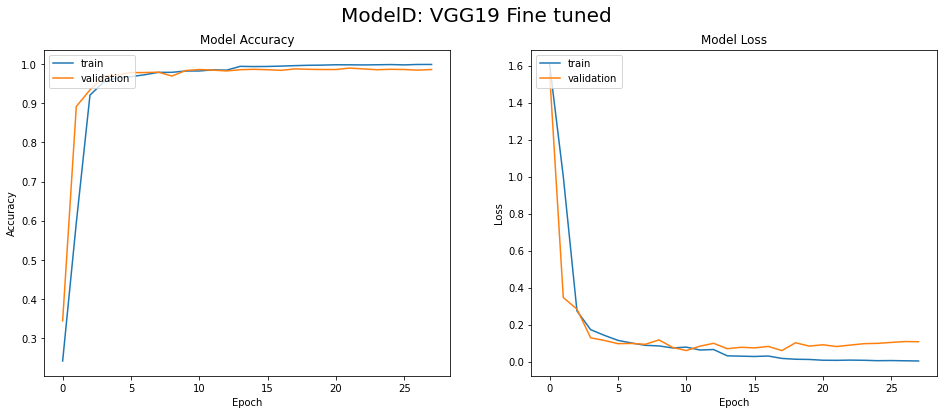

In [6]:
## Results ###
test_loss, test_acc = model.evaluate(X_test,y_test_d)
print(f"test loss: {test_loss}, test acc: {test_acc}")
plot_history(history,"ModelD: VGG19 Fine tuned")

<h1> ModelY - the same precedure the first time</h1>
<h3>ModelY has 11 output labels. The model is made to accomodate that</h3>

In [4]:
base_model = VGG19(
    input_shape=(100,150,3), # refers to the shape we transfer from
    include_top=False, # cut off the head
    weights='imagenet', # pretrained on the ImageNet data
)
base_model.trainable = True
set_trainable = False
unlock = ['block5_conv1','block5_conv2','block5_conv3','block5_conv4']
for layer in base_model.layers:
    if layer.name in unlock:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
modelY = Sequential()
modelY.add(data_augmentation)
modelY.add(base_model)
modelY.add(Flatten())
modelY.add(Dense(1024,activation = 'relu'))
modelY.add(Dropout(0.4))
modelY.add(Dense(11, activation="softmax"))

modelY.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [5]:
X_train, X_test, y_train_y, y_test_y = train_test_split(X, y_y, test_size=0.2, shuffle=True, stratify=y_y)
X_train, X_val, y_train_y, y_val_y = train_test_split(X_train, y_train_y, test_size=0.2, random_state=1, stratify=y_train_y)

historyY = modelY.fit(
    X_train,y_train_y, 
    epochs=100,
    batch_size=8,
    validation_data=(X_val,y_val_y),
    callbacks=[early_stopping,reduced_learnrate])

Epoch 1/100
960/960 [==============================] - 40s 39ms/step - loss: 1.1836 - accuracy: 0.5975 - val_loss: 0.4257 - val_accuracy: 0.8719 - lr: 1.0000e-04
Epoch 2/100
960/960 [==============================] - 37s 39ms/step - loss: 0.4558 - accuracy: 0.8691 - val_loss: 0.3029 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 3/100
960/960 [==============================] - 36s 38ms/step - loss: 0.3154 - accuracy: 0.9116 - val_loss: 0.2911 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 4/100
960/960 [==============================] - 37s 38ms/step - loss: 0.2654 - accuracy: 0.9299 - val_loss: 0.2572 - val_accuracy: 0.9312 - lr: 1.0000e-04
Epoch 5/100
960/960 [==============================] - 37s 39ms/step - loss: 0.2188 - accuracy: 0.9419 - val_loss: 0.2096 - val_accuracy: 0.9438 - lr: 1.0000e-04
Epoch 6/100
960/960 [==============================] - 37s 38ms/step - loss: 0.1858 - accuracy: 0.9478 - val_loss: 0.2960 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 7/100
960/960 [=======

In [8]:
modelY.save('modelY_Vgg19.h5')

75/75 [==============================] - 3s 39ms/step - loss: 0.4542 - accuracy: 0.9496
test loss: 0.45415863394737244, test acc: 0.9495833516120911


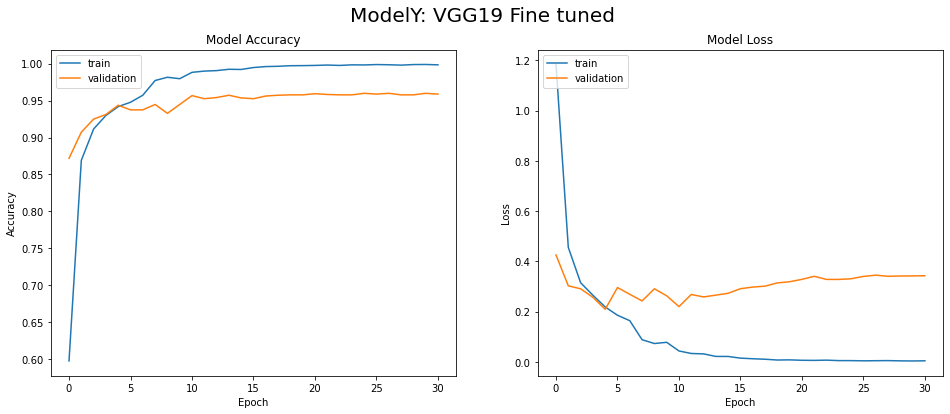

In [11]:
## Results ###
test_loss, test_acc = modelY.evaluate(X_test,y_test_y)
print(f"test loss: {test_loss}, test acc: {test_acc}")
plot_history(historyY,"ModelY: VGG19 Fine tuned")

<h1> ModelCC - the same precedure the first time</h1>
<h3>ModelCC has only 2 output labels. The model is made to accomodate that</h3>

In [3]:
base_model = VGG19(
    input_shape=(100,150,3), # refers to the shape we transfer from
    include_top=False, # cut off the head
    weights='imagenet', # pretrained on the ImageNet data
)
base_model.trainable = True
set_trainable = False
unlock = ['block5_conv1','block5_conv2','block5_conv3','block5_conv4']
for layer in base_model.layers:
    if layer.name in unlock:
        set_trainable = True
    if set_trainable:
        layer.trainable = True 
    else:
        layer.trainable = False
modelCC = Sequential()
modelCC.add(data_augmentation)
modelCC.add(base_model)
modelCC.add(Flatten())
modelCC.add(Dense(1024,activation = 'relu'))
modelCC.add(Dropout(0.4))
modelCC.add(Dense(1, activation="sigmoid"))

modelCC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [4]:
X_train, X_test, y_train_cc, y_test_cc = train_test_split(X, y_cc, test_size=0.2, shuffle=True, stratify=y_cc)
X_train, X_val, y_train_cc, y_val_cc = train_test_split(X_train, y_train_cc, test_size=0.2, random_state=1, stratify=y_train_cc)

historyCC = modelCC.fit(
    X_train,y_train_cc, 
    epochs=100,
    batch_size=16,
    validation_data=(X_val,y_val_cc),
    callbacks=[early_stopping,reduced_learnrate])

Epoch 1/100
480/480 [==============================] - 26s 48ms/step - loss: 0.0770 - accuracy: 0.9803 - val_loss: 0.0384 - val_accuracy: 0.9880 - lr: 1.0000e-04
Epoch 2/100
480/480 [==============================] - 22s 46ms/step - loss: 0.0298 - accuracy: 0.9918 - val_loss: 0.0254 - val_accuracy: 0.9922 - lr: 1.0000e-04
Epoch 3/100
480/480 [==============================] - 22s 45ms/step - loss: 0.0180 - accuracy: 0.9953 - val_loss: 0.0356 - val_accuracy: 0.9922 - lr: 1.0000e-04
Epoch 4/100
480/480 [==============================] - 22s 46ms/step - loss: 0.0332 - accuracy: 0.9943 - val_loss: 0.0358 - val_accuracy: 0.9932 - lr: 1.0000e-04
Epoch 5/100
480/480 [==============================] - 22s 46ms/step - loss: 0.0133 - accuracy: 0.9967 - val_loss: 0.0267 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 6/100
480/480 [==============================] - 22s 46ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.1008 - val_accuracy: 0.9896 - lr: 1.0000e-04
Epoch 7/100
480/480 [=======

In [8]:
modelCC.save('modelCC_Vgg19.h5')

75/75 [==============================] - 3s 40ms/step - loss: 0.0217 - accuracy: 0.9971
test loss: 0.02167460508644581, test acc: 0.997083306312561


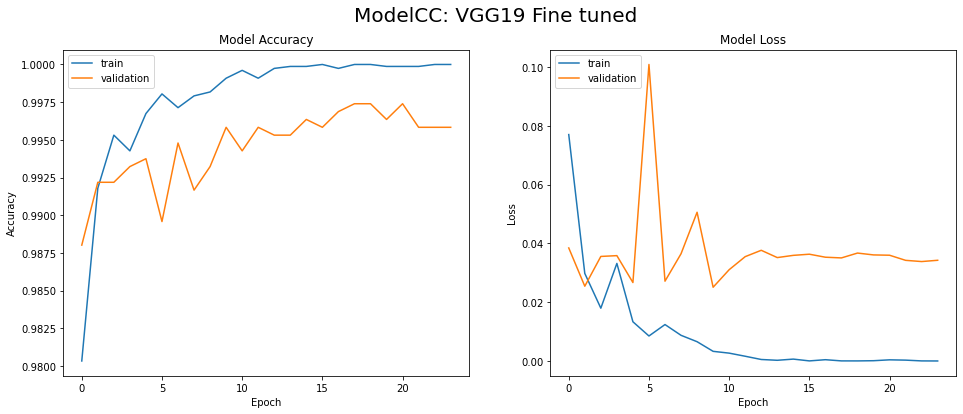

In [9]:
## Results ###
test_loss, test_acc = modelCC.evaluate(X_test,y_test_cc)
print(f"test loss: {test_loss}, test acc: {test_acc}")
plot_history(historyCC,"ModelCC: VGG19 Fine tuned")